<a href="https://colab.research.google.com/github/ankile/Adversarial-Diffusion/blob/main/src/Adversarial_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Diffusion adversarial example creation

The following two cells must be run before restarting the runtime to ensure that the `tiatoolbox` package loads correctly.

In [ ]:
%%capture
!pip install tiatoolbox    

In [ ]:
%%capture
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools

In [ ]:
%%capture
!apt-get -y install libopenjp2-7-dev libopenjp2-tools openslide-tools
!pip install tiatoolbox
!pip install sklearn
!pip install tqdm
!pip install diffusers[training]==0.5.1

In [ ]:
import numpy as np
import torch
from torch import optim
from torch import nn
from sklearn.metrics import accuracy_score
from tiatoolbox.models.architecture import get_pretrained_model
from torchvision.datasets import pcam
from torchvision import transforms
from tiatoolbox.models.dataset.classification import predefined_preproc_func
import matplotlib.pyplot as plt
from tqdm import tqdm
from diffusers import DDPMScheduler

In [ ]:
preprocess_pcam = predefined_preproc_func("pcam")

val_data = pcam.PCAM(root="data", split="val", download=True, transform=preprocess_pcam.func)
test_data = pcam.PCAM(root="data", split="test", download=True, transform=preprocess_pcam.func)

In [ ]:
model_selection = "resnet101"
cnn = get_pretrained_model(pretrained_model=f'{model_selection}-pcam')[0].to("cuda").eval()

## Create Adversarial Examples and Evaluate Model

In [ ]:
def create_adverserial(image, true):

    delta = torch.zeros_like(image, requires_grad=True)
    epsilon = 2/255
    opt = optim.Adam([delta], lr=1e5)

    for t in range(5):
        pred = cnn((image+delta).to("cuda").unsqueeze(0))
        #print(pred)
        loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([true]).to("cuda"))
        
        opt.zero_grad()
        loss.backward()
        opt.step()
        delta.data.clamp_(-epsilon, epsilon)
    return image+delta


In [ ]:
def plot(image):
  plt.imshow(image.detach().numpy().transpose(1,2,0))

In [ ]:
preds_adv = np.array([])
preds_pur = np.array([])
ys = np.array([])
y_counter = 0

for i in range(1000):
    
  Adv, X, y = purified[i]
  X = X.to("cuda")
  Adv = Adv.to("cuda") 
  pred_pur = cnn(X)
  pred_adv = cnn(Adv)
  preds_adv = np.append(preds_adv,np.argmax(pred_adv.detach().cpu().numpy(),axis=1))
  preds_pur = np.append(preds_pur,np.argmax(pred_pur.detach().cpu().numpy(),axis=1))
  y_counter+=y.numpy()
  ys = np.append(ys, y.numpy())

In [ ]:
print("Adverserial: ",accuracy_score(ys,preds_adv))
print("Normal: ",accuracy_score(ys,preds_pur))

Adverserial:  0.749
Normal:  0.846


In [ ]:
basepath = "/content/drive/MyDrive/ML Final Project Fall 22/adverserial_examples"

noises_levels = [5, 20, 30, 35, 40, 42, 45, 50, 60, 70, 80, 90, 100, 120, 140, 200, 300]

datasets = []

for noise_level in noise_levels:
    datasets.append(
        torch.load(f"{basepath}/purified_100_t={noise_level}.pt")   
    )

In [ ]:
accs = []

def get_accuracy(data):
  preds = np.array([])
  ys = np.array([])
  for i in range(100):
    X, y = data[i]
    X = X.to("cuda")
    pred = cnn(X)
    preds = np.append(preds, np.argmax(pred.detach().cpu().numpy(), axis=1))
    ys = np.append(ys, y.numpy())

  accs.append(accuracy_score(ys,preds))
  print(accuracy_score(ys,preds))

for i in datasets:
  get_accuracy(i)

## Plot the accuracy for different noise levels $t$

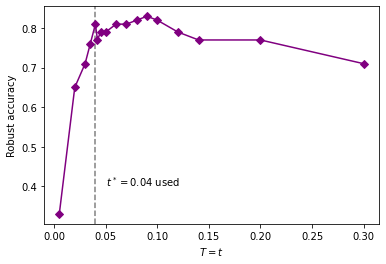

In [ ]:
plt.axvline(0.04, linestyle='--', color="grey",label="Used timestep")
plt.plot(np.array(noises)/1000,accs,"-D",color="purple")
plt.xlabel(r"$T=t$")
plt.ylabel("Robust accuracy")#
plt.text(0.05, 0.4, "$t^*=0.04$ used")
plt.savefig("/content/drive/MyDrive/ML Final Project Fall 22/figures/noise_cv.png")

## Plot example images from different points in the pipeline

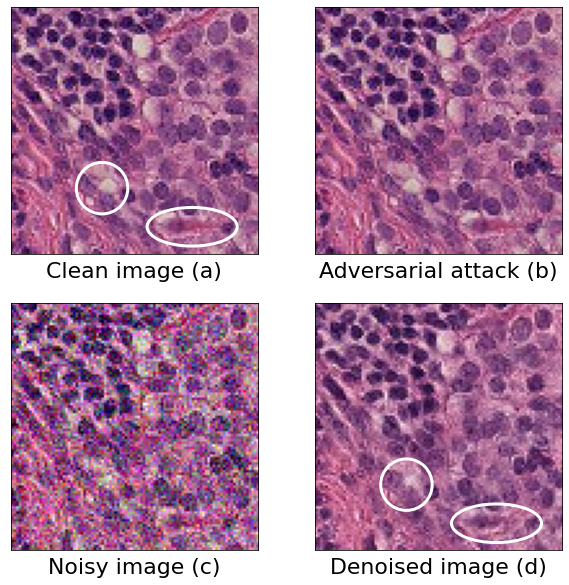

In [ ]:
from matplotlib.patches import Ellipse

plt.rcParams.update({'font.size': 22})
fig,axs=plt.subplots(2,2,figsize=(10,10))
axs[0,0].imshow(X.detach().numpy().transpose(1,2,0))
axs[0,1].imshow(Adv.detach().numpy().transpose(1,2,0))
axs[1,0].imshow(noisy.detach().numpy().transpose(1,2,0))
axs[1,1].imshow(Adv_diff.squeeze(0).detach().numpy().transpose(1,2,0))

axs.flatten()[0].set_xlabel("Clean image (a)")
axs.flatten()[1].set_xlabel("Adversarial attack (b)")
axs.flatten()[2].set_xlabel("Noisy image (c)")
axs.flatten()[3].set_xlabel("Denoised image (d)")
for x in range(4):
  axs.flatten()[x].set_xticks([],[])
  axs.flatten()[x].set_yticks([],[])

circle = plt.Circle( ( 35, 70 ), 10, fill=False, edgecolor="white", linewidth = 3 )
ell=Ellipse((70,85), 35, 15, angle=0,fill=False, edgecolor="white", linewidth = 3)
axs.flatten()[3].add_patch(circle)
axs.flatten()[3].add_patch(ell) 

circle = plt.Circle( ( 35, 70 ), 10, fill=False, edgecolor="white", linewidth = 3 )
ell=Ellipse((70,85), 35, 15, angle=0,fill=False, edgecolor="white", linewidth = 3)
axs.flatten()[0].add_patch(circle)
axs.flatten()[0].add_patch(ell) 
plt.savefig("/content/drive/MyDrive/ML Final Project Fall 22/figures/images_tissue.png")
plt.show();
